In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import cv2
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from keras import layers, Model, models, callbacks, applications
from tensorflow_probability import layers as tfp_layers

In [2]:
print(tf.__version__, tfp.__version__, tf.keras.__version__)

2.18.0 0.25.0 3.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = "/content/drive/MyDrive/TFG"
CITYSCAPES_PATH = dir + "/Cityscapes"
IMGS_PATH =  os.path.join(CITYSCAPES_PATH, "leftImg8bit")
MASKS_PATH = os.path.join(CITYSCAPES_PATH, "gtFine")

In [5]:
data_shape = 256*512  # Nueva resolución de las imágenes (originalmente 1024x2048)
label_colors = {
    "unlabeled": [0, 0, 0],
    "ego vehicle": [0, 0, 0],
    "rectification border": [0, 0, 0],
    "out of roi": [0, 0, 0],
    "static": [0, 0, 0],
    "dynamic": [111, 74,  0],
    "ground": [81,  0, 81],
    "road": [128, 64,128],
    "sidewalk": [244, 35,232],
    "parking": [250,170,160],
    "rail track": [230,150,140],
    "building": [70, 70, 70],
    "wall": [102,102,156],
    "fence": [190,153,153],
    "guard rail": [180,165,180],
    "bridge": [150,100,100],
    "tunnel": [150,120, 90],
    "pole": [153,153,153],
    "polegroup": [153,153,153],
    "traffic light": [153,153,153],
    "traffic sign": [250,170, 30],
    "vegetation": [107,142, 35],
    "terrain": [152,251,152],
    "sky": [70,130,180],
    "person": [220, 20, 60],
    "rider": [255, 0, 0],
    "car": [ 0,  0,142],
    "truck": [0,  0, 70],
    "bus": [ 0, 60,100],
    "caravan": [ 0,  0, 90],
    "trailer": [ 0,  0,110],
    "train": [ 0, 80,100],
    "motorcycle": [0,  0,230],
    "bicycle": [119, 11, 32],
    "license plate": [0,0,142]
}
reduced_label_colors = {
    "background": [46,0,137],  # Azul oscuro
    "vehicle": [255, 255, 0],  # Amarillo
    "person": [255, 0, 0],  # Rojo
    "road": [128, 128, 128]  # Gris
}
num_classes = 4

In [6]:
train_data = np.load('/content/drive/MyDrive/TFG/data3/train_data.npy')
train_label = np.load('/content/drive/MyDrive/TFG/data3/train_label.npy')
val_data = np.load('/content/drive/MyDrive/TFG/data3/val_data.npy')
val_label = np.load('/content/drive/MyDrive/TFG/data3/val_label.npy')
test_data = np.load('/content/drive/MyDrive/TFG/data3/test_data.npy')
test_label = np.load('/content/drive/MyDrive/TFG/data3/test_label.npy')

In [7]:
color_array = np.array(list(reduced_label_colors.values()))
def visualize(temp, plot=False):
    temp = np.argmax(temp, axis=-1).reshape((256,512))
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(len(color_array)):
        r[temp == l] = color_array[l, 0]
        g[temp == l] = color_array[l, 1]
        b[temp == l] = color_array[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0

    if plot:
        plt.imshow(rgb)
    else:
        return rgb

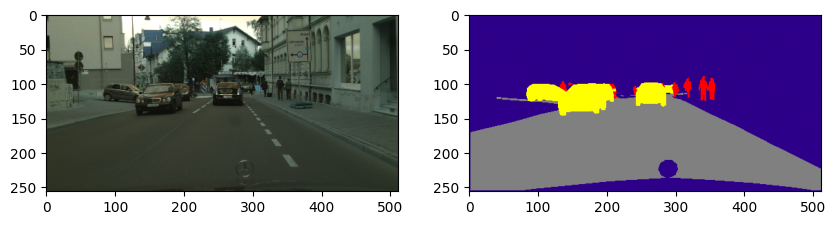

In [8]:

# Encuentra la clase con el valor 1 (por cada píxel, hay un solo valor 1 en su respectiva clase)
# Esto crea una imagen de las etiquetas con valores [0, 1, 2, ..., 18] en vez de one-hot.
imagen_rgb_segmentada = visualize(train_label[0])
# Muestra la imagen etiquetada usando los colores de `label_colors`
# Primero, convertimos la etiqueta en colores
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(train_data[0])
axs[1].imshow(imagen_rgb_segmentada)
plt.show()  # Asegura que se rendericen los gráficos

In [9]:
def calculate_class_weights(y_true):
    # Convertir etiquetas one-hot a índices
    y_true = np.argmax(y_true, axis=-1) #(num_datos, H, W) donde cada valor es el índice de la clase de cada píxel.

    # Calcular la frecuencia de cada clase
    class_counts = np.bincount(y_true.flatten()) #class_counts: (num_classes,) → Número de ocurrencias por clase
    total_samples = np.sum(class_counts)     # total_samples: escalar (cantidad total de píxeles/elementos)

    # Evitar divisiones por cero
    class_counts = np.maximum(class_counts, 1)

    # peso(c) = total_muestras_c/ (numero_clasesxfrecuencia(c)) es inversamente proporcional a la frecuencia de la clase.
    class_weights = total_samples / (len(class_counts) * class_counts)
    #class_weights = total_samples / (len(class_counts) * np.log1p(class_counts))

    return class_weights
calculate_class_weights(train_label)

array([ 0.43318992,  3.70421804, 16.32369639,  0.73512084])

In [10]:
import tensorflow.keras.backend as K

# Definir los pesos para cada clase (Background, Vehicle, Person)
#class_weights = np.array([0.2,  # Background
#                          0.8,  # Vehicle
#                          1.0,# Person (prioridad máxima)
#                          0.2]) # Road
class_weights = calculate_class_weights(train_label)
#class_weights = np.array([ 0.6,  4.5, 10.5,  1])
#class_weights = np.array([ 0.6,  3.5, 5.,  1])
# Función de pérdida ponderada
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * weights, axis=-1)
    return loss

# Aplicar la función de pérdida personalizada en el modelo
loss_function = weighted_categorical_crossentropy(class_weights)

In [11]:
train_data.shape, train_label.shape, val_data.shape, val_label.shape, test_data.shape, test_label.shape

((1475, 256, 512, 3),
 (1475, 131072, 4),
 (150, 256, 512, 3),
 (150, 131072, 4),
 (60, 256, 512, 3),
 (60, 131072, 4))

In [12]:
train_label = train_label.reshape(-1, 256, 512, 4)
val_label = val_label.reshape(-1, 256, 512, 4)
test_label = test_label.reshape(-1, 256, 512, 4)

In [13]:
class_weights = np.array([ 0.6,  2, 4.4,  0.8])
loss_function = weighted_categorical_crossentropy(class_weights)

In [14]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convertir etiquetas one-hot a índices
        y_true = tf.argmax(y_true, axis=-1)  # De (B, H, W, C) → (B, H, W)
        y_pred = tf.argmax(y_pred, axis=-1)  # Lo mismo para las predicciones

        return super().update_state(y_true, y_pred, sample_weight)

In [15]:
early_stopping = callbacks.EarlyStopping(
    patience=8,               # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True, # Restaura los mejores pesos al finalizar
)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")  # Desactiva la cuadrícula
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})


def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy') or history.history.get('acc')
    val_accuracy = history.history.get('val_accuracy') or history.history.get('val_acc')
    miou = history.history.get('mean_iou') or history.history.get('mIoU')
    val_miou = history.history.get('val_mean_iou') or history.history.get('val_mIoU')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 6))

    # Graficar la pérdida (loss)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, marker='o', color='#1f77b4', linewidth=2, label='Entrenamiento')
    if val_loss:
        plt.plot(epochs, val_loss, marker='o', color='#ff7f0e', linewidth=2, linestyle='--', label='Validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc='upper right')

    # Graficar la precisión (accuracy)
    if accuracy:
        plt.subplot(1, 3, 2)
        plt.plot(epochs, accuracy, marker='o', color='#2ca02c', linewidth=2, label='Entrenamiento')
        if val_accuracy:
            plt.plot(epochs, val_accuracy, marker='o', color='#d62728', linewidth=2, linestyle='--', label='Validación')
        plt.title('Precisión durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')
        plt.legend(loc='lower right')

    # Graficar el mIoU
    if miou:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, miou, marker='o', color='#9467bd', linewidth=2, label='mIoU (Entrenamiento)')
        if val_miou:
            plt.plot(epochs, val_miou, marker='o', color='#8c564b', linewidth=2, linestyle='--', label='mIoU (Validación)')
        plt.title('mIoU durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('mIoU')
        plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

##MODELO NO BAYESIANO

In [ ]:
def build_segnet(input_shape=(256, 512, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    model = models.Model(inputs, outputs, name="Custom_SegNet")

    return model

# Crear modelo
model_nobay = build_segnet()
model_nobay.summary()

In [ ]:
#Fine tuning
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 512, 3))
vgg16 = base_model
for layer, vgg_layer in zip(model_nobay.layers, vgg16.layers):
        if "conv" in layer.name:
            layer.set_weights(vgg_layer.get_weights())
            layer.trainable = True  # Opcional: congelar pesos preentrenados

In [ ]:
model_nobay.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=loss_function, #esto se debe a que tenemos las clases en formato one-hot
    metrics=['accuracy',MeanIoU(num_classes=num_classes)]
)

In [ ]:
history = model_nobay.fit(
     train_data,
      train_label,
      epochs=100,
      batch_size=25,
      steps_per_epoch=59, #59x25=1475
      validation_data=(val_data, val_label),
      callbacks=[early_stopping],
      verbose=2)

In [ ]:
#model_nobay.save_weights("/content/drive/MyDrive/TFG/weights/Modelo_No_Bay_Mas_Datos_PesosMediosFinal.weights.h5")

In [ ]:
model_nobay.load_weights("/content/drive/MyDrive/TFG/weights/visualizar/Modelo_No_Bay_Mas_Datos_PesosMediosFinal.weights.h5")

##MODELO BAYESIANO


In [17]:
def build_segnet2(input_shape=(256, 512, 3), num_classes=4, droprate=0.7):
    # Cargar VGG16 sin las capas fully connected
    vgg16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    inputs = vgg16.input
    x = vgg16.layers[1](inputs)

    i = -6
    for layer in vgg16.layers[2:]:
        x = layer(x)
        # Agregar Dropout en los últimos 3 bloques del encoder
        if 'pool' in layer.name and i >= 0:
            x = layers.Dropout(droprate)(x, training=True)
        i += 1

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)


    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    #x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Crear el modelo completo
    model = models.Model(inputs, outputs, name='Custom_SegNet_MCDrop')

    return model

# Crear y mostrar el modelo
model_mcdrop = build_segnet2()
model_mcdrop.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "Custom_SegNet_MCDrop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 128, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 32, 512)    │     2,359,80

 Total params: 31,750,276 (121.12 MB)

 Trainable params: 31,750,276 (121.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_mcdrop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=loss_function, #esto se debe a que tenemos las clases en formato one-hot
     metrics=['accuracy',MeanIoU(num_classes=num_classes)]
)

In [ ]:
history = model_mcdrop.fit(
      train_data,
      train_label,
      epochs=100,
      batch_size=25,
      steps_per_epoch=59, #25*59=1475
      validation_data=(val_data, val_label),
      callbacks=[early_stopping],
      verbose=2)

Epoch 1/100
59/59 - 35s - 592ms/step - accuracy: 0.6078 - loss: 0.8585 - mean_iou: 0.2269 - val_accuracy: 0.7778 - val_loss: 0.6209 - val_mean_iou: 0.3389
Epoch 2/100
59/59 - 16s - 278ms/step - accuracy: 0.8265 - loss: 0.5630 - mean_iou: 0.3794 - val_accuracy: 0.8366 - val_loss: 0.5328 - val_mean_iou: 0.3966
Epoch 3/100
59/59 - 16s - 277ms/step - accuracy: 0.8400 - loss: 0.4979 - mean_iou: 0.4068 - val_accuracy: 0.8592 - val_loss: 0.4490 - val_mean_iou: 0.5022
Epoch 4/100
59/59 - 16s - 279ms/step - accuracy: 0.8594 - loss: 0.4196 - mean_iou: 0.5076 - val_accuracy: 0.8917 - val_loss: 0.3447 - val_mean_iou: 0.5560
Epoch 5/100
59/59 - 16s - 277ms/step - accuracy: 0.8841 - loss: 0.3629 - mean_iou: 0.5449 - val_accuracy: 0.8994 - val_loss: 0.3355 - val_mean_iou: 0.5683
Epoch 6/100
59/59 - 16s - 277ms/step - accuracy: 0.8902 - loss: 0.3356 - mean_iou: 0.5575 - val_accuracy: 0.9064 - val_loss: 0.3021 - val_mean_iou: 0.5799
Epoch 7/100
59/59 - 16s - 278ms/step - accuracy: 0.8973 - loss: 0.3143

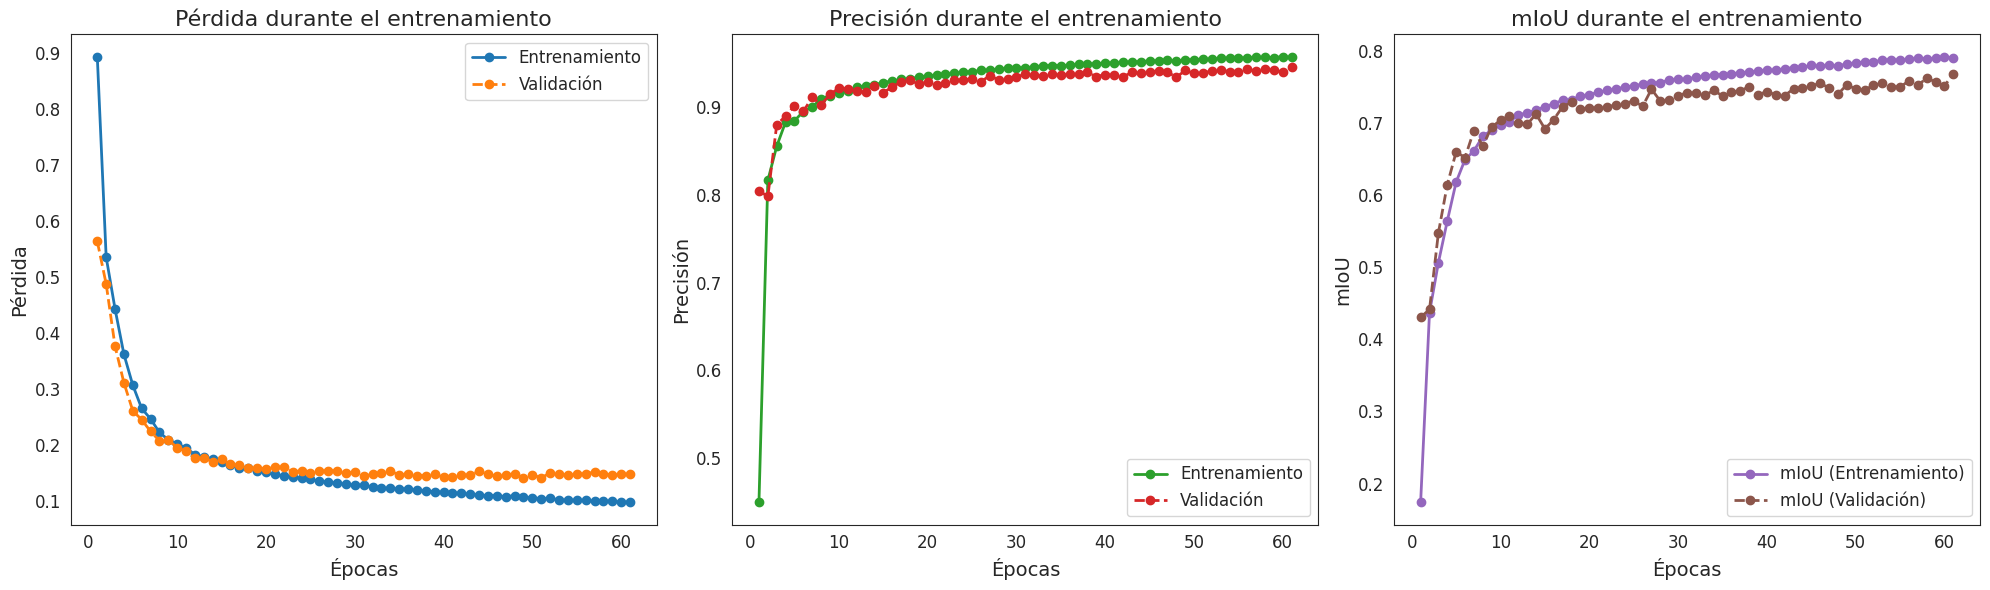

In [ ]:
plot_history(history)

In [ ]:
#model_mcdrop.save_weights("/content/drive/MyDrive/TFG/weights/Modelo_MCDROP_Mas_Datos_PesosMediosFinal_CAPA_MAS.weights.h5")

In [18]:
model_mcdrop.load_weights("/content/drive/MyDrive/TFG/weights/visualizar/Modelo_MCDROP_Mas_Datos_PesosMediosFinal.weights.h5")

In [24]:
@tf.function
def mc_dropout_inference(model, x, num_samples=10):
    predictions = tf.stack([model(x, training=True) for _ in range(num_samples)])
    return predictions, tf.reduce_mean(predictions, axis=0), tf.math.reduce_variance(predictions, axis=0)

MUESTRA PREDICCIONES

In [22]:
from scipy.stats import entropy
import random

In [20]:
def display(model):
    rand_idx = random.randint(0, len(val_data) - 6)  # Índice inicial aleatorio del test
    num_samples = 50

    f, ax = plt.subplots(5, 5, figsize=(15, 15))  # 5 filas, 5 columnas

    for i in range(5):
        x_sample = np.expand_dims(val_data[rand_idx + i], axis=0)
        test_sample = val_data[rand_idx + i]
        test_label_sample = val_label[rand_idx + i]

        outputs, mean_pred, uncertainty = mc_dropout_inference(model, x_sample, num_samples)
        aleatoric = entropy(mean_pred * 255, axis=-1).squeeze()
        epistemic = np.mean(uncertainty, axis=-1)[0]
        output = mean_pred

        ax[i, 0].imshow(test_sample)
        ax[i, 0].set_title('Imagen Entrada')

        ax[i, 1].imshow(visualize(test_label_sample))
        ax[i, 1].set_title('Realidad')

        ax[i, 2].imshow(visualize(output))
        ax[i, 2].set_title('Segmentacion')

        ax[i, 3].imshow(aleatoric, cmap="viridis")
        ax[i, 3].set_title('Incertidumbre aleatoria')

        ax[i, 4].imshow(epistemic, cmap="viridis")
        ax[i, 4].set_title('Incertidumbre epistémica')

        for j in range(5):
            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

MÉTRICAS:

In [ ]:
def calcular_miou(model, dataset, num_classes, num_samples=10):
    """
    Calcula el mIoU de un modelo de segmentación con MC Dropout.

    Parámetros:
    - model: El modelo de segmentación entrenado.
    - dataset: Un tf.data.Dataset con imágenes y máscaras (imágenes, etiquetas).
    - num_classes: Número de clases para la segmentación.
    - num_samples: Número de muestras para MC Dropout.

    Retorna:
    - mIoU (float): El Mean Intersection over Union.
    """
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    def mc_dropout_inference(model, x, num_samples=10):
        # Asegurar que x tenga un batch dimension
        if len(x.shape) == 3:
            x = tf.expand_dims(x, axis=0)
        predictions = tf.stack([model(x, training=True) for _ in range(num_samples)])
        return predictions, tf.reduce_mean(predictions, axis=0), tf.math.reduce_variance(predictions, axis=0)

    for images, masks_true in dataset:
        # Predicción MC Dropout
        _, preds_mean, _ = mc_dropout_inference(model, images, num_samples)
        preds = tf.argmax(preds_mean, axis=-1)
        preds = tf.cast(preds, tf.int32)

        # Ajustar máscaras verdaderas
        if masks_true.shape[-1] != 1:  # Si la máscara tiene múltiples canales
            masks_true = tf.argmax(masks_true, axis=-1)
        else:
            masks_true = tf.squeeze(masks_true, axis=-1)
        masks_true = tf.cast(masks_true, tf.int32)

        # Cálculo de IoU por clase
        for c in range(num_classes):
            inter = np.logical_and(preds == c, masks_true == c)
            union_c = np.logical_or(preds == c, masks_true == c)
            intersection[c] += np.sum(inter)
            union[c] += np.sum(union_c)

    # Evitar divisiones por cero
    iou = intersection / np.maximum(union, 1)
    miou = np.mean(iou)

    return miou

In [ ]:
def calcular_accuracy(model, dataset, num_samples=10):
    """
    Calcula la accuracy de un modelo de segmentación con MC Dropout.

    Parámetros:
    - model:       El modelo de segmentación entrenado.
    - dataset:     Un tf.data.Dataset que devuelve tuplas (imágenes, máscaras verdaderas).
    - num_samples: Número de inferencias para MC Dropout.

    Retorna:
    - accuracy (float): Fracción de píxeles correctamente clasificados.
    """
    total_correct = 0
    total_pixels  = 0

    def mc_dropout_predict(model, x, num_samples):
        # Asegura dimensión de batch
        if len(x.shape) == 3:
            x = tf.expand_dims(x, axis=0)
        # Obtiene múltiples predicciones (shape: [num_samples, batch, height, width, num_classes])
        preds = tf.stack([model(x, training=True) for _ in range(num_samples)])
        preds_mean = tf.reduce_mean(preds, axis=0)  # Promedio sobre muestras MC
        preds_class = tf.argmax(preds_mean, axis=-1)  # [batch, height, width]
        return preds_class.numpy()

    for images, masks_true in dataset:
        preds = mc_dropout_predict(model, images, num_samples)  # [batch, h, w]

        # Ajustar masks_true a [batch, height, width]
        if masks_true.shape[-1] != 1:
            masks_true = tf.argmax(masks_true, axis=-1)
        else:
            masks_true = tf.squeeze(masks_true, axis=-1)
        masks_true = masks_true.numpy().astype(np.int32)

        total_correct += np.sum(preds == masks_true)
        total_pixels  += np.prod(masks_true.shape)

    return total_correct / total_pixels


In [ ]:
miou_val = calcular_miou(model_mcdrop, tf.data.Dataset.from_tensor_slices((val_data, val_label)), 4, 10)
miou_val

np.float64(0.7694459892753975)

In [ ]:
miou_train = calcular_miou(model_mcdrop, tf.data.Dataset.from_tensor_slices((train_data, train_label)), 4, 10)
miou_train

In [ ]:
acc_val = calcular_accuracy(model_mcdrop, tf.data.Dataset.from_tensor_slices((val_data, val_label)), 10)
acc_val

np.float64(0.945730692545573)

##GRADCAM

In [22]:
model_mcdrop.summary()

Model: "Custom_SegNet_MCDrop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 128, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 32, 512)    │     2,359,80

 Total params: 31,750,276 (121.12 MB)

 Trainable params: 31,750,276 (121.12 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#last_conv_layer_name ="conv2d_90"
last_conv_layer_name ="conv2d_12"

In [35]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index):
    # Crear un modelo que mapea la entrada a las activaciones y predicciones
    grad_model = models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Calcular el gradiente con respecto al mapa de características
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # Asegurar que pred_index es un tensor de tipo int32
        pred_index = tf.constant(pred_index, dtype=tf.int32)

        # Extraer el mapa de predicción de la clase específica
        class_channel = preds[..., pred_index]

    # Calcular el gradiente de la clase de interés respecto a las activaciones
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calcular la media de los gradientes a lo largo de los ejes espaciales
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Obtener el mapa de características sin la dimensión del lote
    last_conv_layer_output = last_conv_layer_output[0]

    # Ponderar el mapa de características por la importancia de cada canal
    heatmap = tf.reduce_sum(last_conv_layer_output * pooled_grads, axis=-1)

    # Normalizar el heatmap a [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

In [36]:
def plot_class_heatmaps(img_arrays, model, last_conv_layer_name, val_labels):
    num_images = len(img_arrays)
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))

    for idx, (img_array, val_label) in enumerate(zip(img_arrays, val_labels)):
        # Mostrar la imagen original
        axes[idx, 0].imshow(img_array)
        axes[idx, 0].set_title(f'Imagen {idx+1} Original', fontsize=14, fontweight='bold')
        axes[idx, 0].axis('off')


        # Mostrar la imagen segmentada
        segmented_image = val_label
        axes[idx, 1].imshow(visualize(segmented_image))
        axes[idx, 1].set_title(f'Segmentación Imagen {idx+1}', fontsize=14, fontweight='bold')
        axes[idx, 1].axis('off')

        # Generar y graficar el heatmap para la clase 2
        heatmap2 = make_gradcam_heatmap(np.expand_dims(img_array, axis=0), model, last_conv_layer_name, 1)
        axes[idx, 2].imshow(heatmap2, cmap='viridis', alpha=0.85)
        axes[idx, 2].set_title(f'GradCAM Vehículos', fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')

        # Generar y graficar el heatmap para la clase 3
        heatmap3 = make_gradcam_heatmap(np.expand_dims(img_array, axis=0), model, last_conv_layer_name, 2)
        axes[idx, 3].imshow(heatmap3, cmap='magma', alpha=0.85)
        axes[idx, 3].set_title(f'GradCAM Personas', fontsize=12, fontweight='bold')
        axes[idx, 3].axis('off')

    plt.tight_layout()
    plt.show()


In [37]:
img_array = train_data[4:6]
label_array = train_label[4:6]

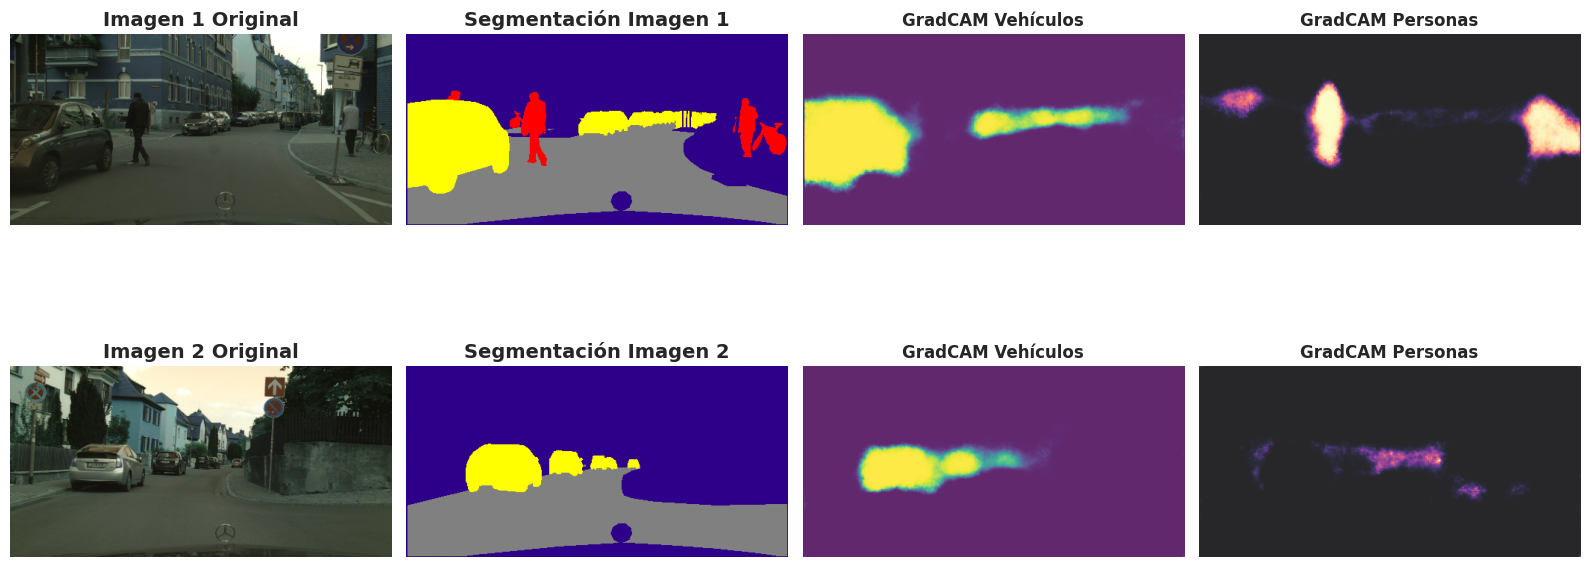

In [38]:
plot_class_heatmaps(img_array, model_mcdrop, last_conv_layer_name, label_array)

##SKIP CONNECTIONS

In [17]:
def build_segnet_skip_connections(input_shape=(256, 512, 3), num_classes=4, droprate=0.55):
    # Cargar VGG16 sin las capas fully connected
    vgg16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    inputs = vgg16.input
    x = vgg16.layers[1](inputs)

    # Encoder con almacenamiento de activaciones para skip connections
    skip_connections = []
    #i = -6
    for layer in vgg16.layers[2:]:
        x = layer(x)
        if 'pool' in layer.name:
            skip_connections.append(x)  # Guardamos la activación para skip connection
            #if i >= 0:
            x = layers.Dropout(droprate)(x, training=True)
            #i += 1

    # Invertir el orden de las skip connections para alinearlas con el decoder
    skip_connections = skip_connections[::-1]

    # Decoder con skip connections
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.Concatenate()([x, skip_connections[1]])  # Skip connection
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.Concatenate()([x, skip_connections[2]])  # Skip connection
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    x = layers.Concatenate()([x, skip_connections[3]])  # Skip connection
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(droprate)(x, training=True)

    #x = layers.Concatenate()([x, skip_connections[4]])  # Skip connection
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Dropout(0.25)(x, training=True)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Crear el modelo completo
    model = models.Model(inputs, outputs, name='SegNet_Skip_MCDrop')

    return model

# Crear y mostrar el modelo
model_mcdrop_skip = build_segnet_skip_connections()
model_mcdrop_skip.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "SegNet_Skip_MCDrop"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 512,  │     36,928 │ block1_conv1[1][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 256,  │          0 │ block1_conv2[1][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 256,  │          0 │ block1_pool[1][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 256,  │     73,856 │ dropout[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 256,  │    147,584 │ block2_conv1[1][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 128,   │          0 │ block2_conv2[1][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128,   │          0 │ block2_pool[1][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 128,   │    295,168 │ dropout_1[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 128,   │    590,080 │ block3_conv1[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 128,   │    590,080 │ block3_conv2[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 64,    │          0 │ block3_conv3[1][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 64,    │          0 │ block3_pool[1][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 64,    │  1,180,160 │ dropout_2[0][0]   │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 64,    │  2,359,808 │ block4_conv1[1][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 64,    │  2,359,808 │ block4_conv2[1][

 Total params: 34,846,852 (132.93 MB)

 Trainable params: 34,846,852 (132.93 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_mcdrop_skip.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=loss_function, #esto se debe a que tenemos las clases en formato one-hot
     metrics=['accuracy',MeanIoU(num_classes=num_classes)]
)

In [43]:
history = model_mcdrop_skip.fit(
      train_data,
      train_label,
      epochs=100,
      batch_size=25,
      steps_per_epoch=59, #61x16=976
      validation_data=(val_data, val_label),
      callbacks=[early_stopping],
      verbose=2)

Epoch 1/100
59/59 - 96s - 2s/step - accuracy: 0.4206 - loss: 1.8392 - mean_iou: 0.1820 - val_accuracy: 0.7860 - val_loss: 0.7379 - val_mean_iou: 0.3589
Epoch 2/100
59/59 - 17s - 288ms/step - accuracy: 0.7049 - loss: 0.8106 - mean_iou: 0.3542 - val_accuracy: 0.8280 - val_loss: 0.5498 - val_mean_iou: 0.4306
Epoch 3/100
59/59 - 17s - 288ms/step - accuracy: 0.7660 - loss: 0.6491 - mean_iou: 0.4173 - val_accuracy: 0.8572 - val_loss: 0.4946 - val_mean_iou: 0.5071
Epoch 4/100
59/59 - 17s - 289ms/step - accuracy: 0.8040 - loss: 0.5577 - mean_iou: 0.4670 - val_accuracy: 0.8406 - val_loss: 0.4458 - val_mean_iou: 0.5116
Epoch 5/100
59/59 - 17s - 290ms/step - accuracy: 0.8254 - loss: 0.4970 - mean_iou: 0.5036 - val_accuracy: 0.8495 - val_loss: 0.3980 - val_mean_iou: 0.5390
Epoch 6/100
59/59 - 17s - 289ms/step - accuracy: 0.8425 - loss: 0.4461 - mean_iou: 0.5355 - val_accuracy: 0.8736 - val_loss: 0.3599 - val_mean_iou: 0.5890
Epoch 7/100
59/59 - 17s - 290ms/step - accuracy: 0.8551 - loss: 0.4068 - 

In [44]:
model_mcdrop_skip.save_weights("/content/drive/MyDrive/TFG/weights/visualizar/Modelo_Mcdrop_skip.weights.h5")

In [18]:
model_mcdrop_skip.load_weights("/content/drive/MyDrive/TFG/weights/visualizar/Modelo_Mcdrop_skip.weights.h5")

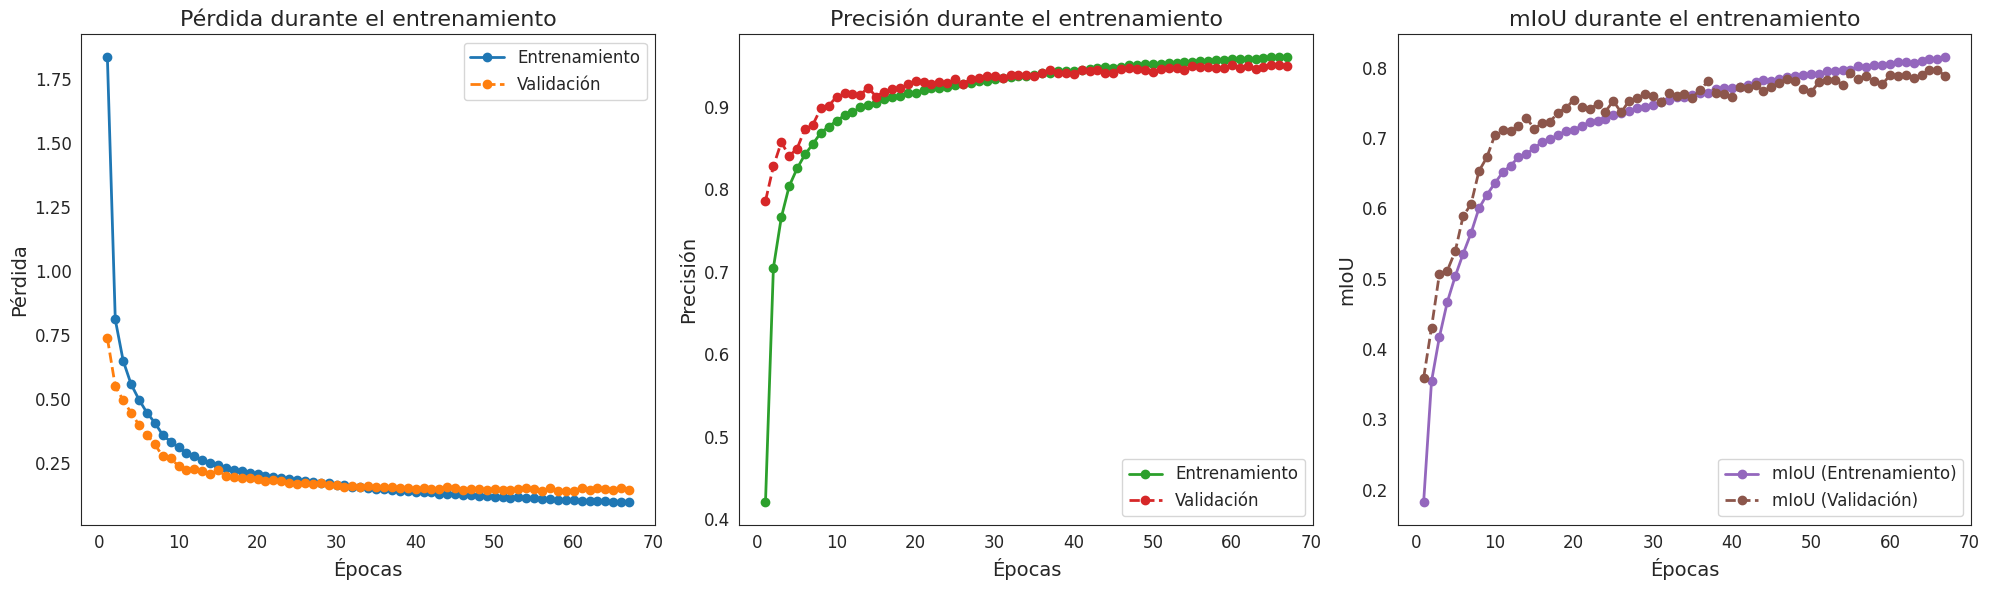

In [46]:
plot_history(history)

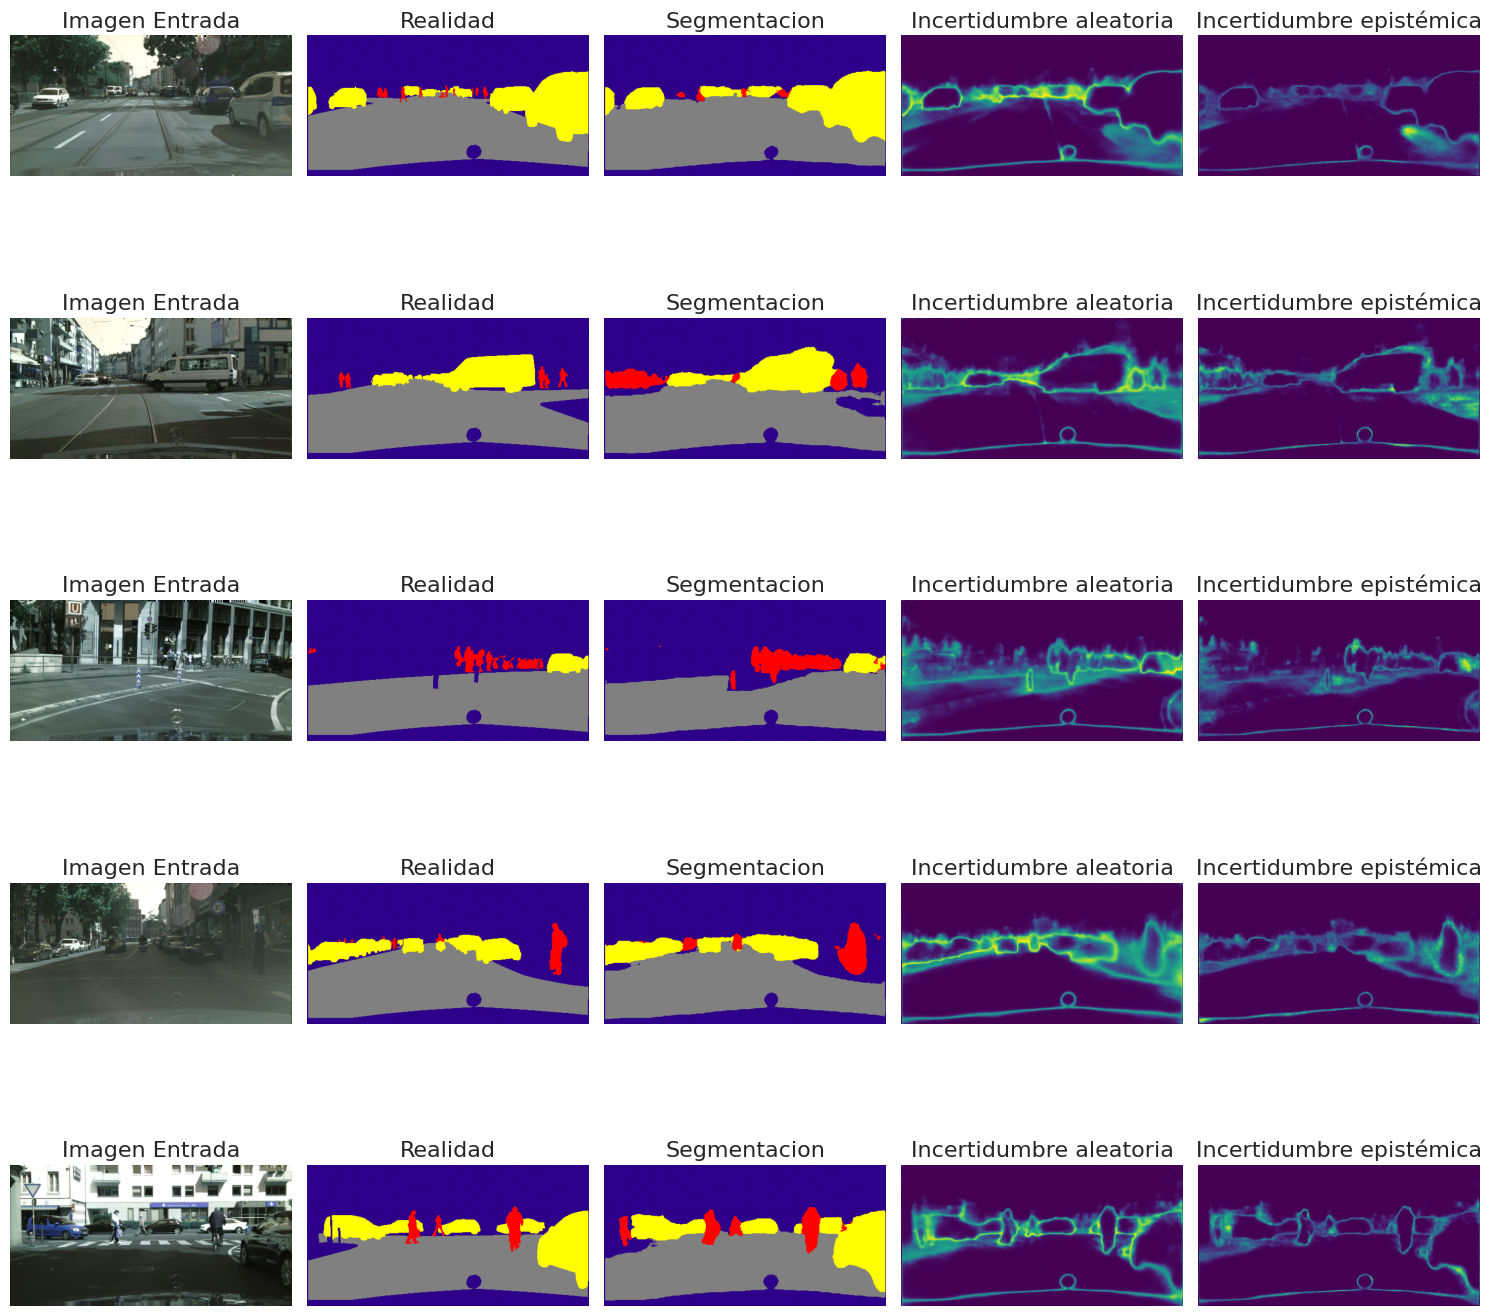

In [38]:
display(model_mcdrop_skip)

In [ ]:
#59/59 - 17s - 290ms/step - accuracy: 0.9571 - loss: 0.1049 - mean_iou: 0.8038 - val_accuracy: 0.9473 - val_loss: 0.1405 - val_mean_iou: 0.7764